# Final project
The goal is to predict the pollution in a particular point of a city for the next few hours. The prediction will take as input from the data collected by sensors of air pollution and number of vehicles. We will train different models and evaluate the results to choose the best predictions in each case. The project includes:

+ Basic data management to prepare the data
+ Basic statistics to understand the data and detect outliers
+ Clustering for selecting days with similar pollution/traffic conditions
+ Feature selection
+ Hiperparameter tunning
+ Model Selection

## Setup

In [2]:
import os.path
from subprocess import check_call
import importlib
import os
import sys
import findspark
import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession

modules = ["findspark","pyspark"]

def check_modules(modules, upgrade=False):
    print("Checking required modules")
    for m in modules:
        torch_loader = importlib.util.find_spec(m)
        if torch_loader is not None and not upgrade:
            print(m," found")
        else:
            if upgrade:
                print("upgrading ",m)
            else:
                print(m," not found, installing")
            if 'google.colab' in sys.modules:
                if upgrade:
                    check_call(["pip", "install", "--upgrade", m])
                else:
                    check_call(["pip", "install", "-q", m])
            else:
                if upgrade:
                    check_call([sys.executable, "-m", "pip", "install", "--user", "--upgrade", m])
                else:
                    check_call([sys.executable, "-m", "pip", "install", "--user", m])

check_modules(modules,upgrade=False)

findspark.init()
spark = SparkSession.builder.getOrCreate() # SparkSession.builder.getOrCreate()
sc = spark.sparkContext
df = spark.sql('''select 'spark' as hi ''')
df.show()

Checking required modules
findspark  found
pyspark  found


22/04/01 04:24:42 WARN Utils: Your hostname, ubuntu2004 resolves to a loopback address: 127.0.1.1; using 192.168.72.128 instead (on interface ens33)
22/04/01 04:24:42 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/01 04:24:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/04/01 04:24:45 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


+-----+
|   hi|
+-----+
|spark|
+-----+



In [26]:
!pip install missingno

     |████████████████████████████████| 292 kB 276 kB/s eta 0:00:01


## Loading Data

In [3]:
def load_file(file):
    df = spark.read.format("com.databricks.spark.csv")\
            .options(header='true', inferschema='true') \
            .load(file)
    return df

file = "./madpollution.csv"
# load the dataframe
df = load_file(file)
print(f"{df.count()} rows")
df.printSchema()
df.take(10)

27767 rows
root
 |-- date: string (nullable = true)
 |-- laborday: integer (nullable = true)
 |-- saturday: integer (nullable = true)
 |-- sunday: integer (nullable = true)
 |-- holiday: integer (nullable = true)
 |-- CO: double (nullable = true)
 |-- NO: integer (nullable = true)
 |-- NO2: integer (nullable = true)
 |-- PM25: integer (nullable = true)
 |-- PM10: integer (nullable = true)
 |-- NOx: integer (nullable = true)
 |-- O3: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- winddirection: integer (nullable = true)
 |-- temperature: double (nullable = true)
 |-- humidity: integer (nullable = true)
 |-- pressure: integer (nullable = true)
 |-- rain: double (nullable = true)
 |-- traffic: integer (nullable = true)



[Row(date='2019-01-01 00:00:00', laborday=1, saturday=0, sunday=0, holiday=0, CO=0.6, NO=81, NO2=73, PM25=None, PM10=None, NOx=196, O3=3.08, windspeed=0.68, winddirection=48, temperature=2.6, humidity=71, pressure=959, rain=0.0, traffic=904),
 Row(date='2019-01-01 01:00:00', laborday=1, saturday=0, sunday=0, holiday=0, CO=0.8, NO=124, NO2=82, PM25=None, PM10=None, NOx=272, O3=3.05, windspeed=0.69, winddirection=32, temperature=2.5, humidity=71, pressure=959, rain=0.0, traffic=1489),
 Row(date='2019-01-01 02:00:00', laborday=1, saturday=0, sunday=0, holiday=0, CO=0.7, NO=93, NO2=72, PM25=None, PM10=None, NOx=215, O3=3.13, windspeed=0.7, winddirection=43, temperature=1.7, humidity=74, pressure=959, rain=0.0, traffic=1191),
 Row(date='2019-01-01 03:00:00', laborday=1, saturday=0, sunday=0, holiday=0, CO=0.6, NO=86, NO2=66, PM25=None, PM10=None, NOx=198, O3=3.02, windspeed=0.7, winddirection=74, temperature=1.1, humidity=75, pressure=959, rain=0.0, traffic=969),
 Row(date='2019-01-01 04:00

# Preprocesse

In [3]:
# print schema
from pyspark.sql.functions import rand # to shuffle elements
df.orderBy(rand()).show(10)

# drop nulls
def prop_null_coll(df,c):
    total = df.count()
    nuls = df.filter(df[f"`{c}`"].isNull()).count()
    prop = nuls*100/total
    return prop

def printnulls(df):
    for c in  df.columns:
        print(f"Column {c} contains {round(prop_null_coll(df,c),2)}% nulls")
    return
printnulls(df)

+-------------------+--------+--------+------+-------+---+---+---+----+----+---+-----+---------+-------------+-----------+--------+--------+----+-------+
|               date|laborday|saturday|sunday|holiday| CO| NO|NO2|PM25|PM10|NOx|   O3|windspeed|winddirection|temperature|humidity|pressure|rain|traffic|
+-------------------+--------+--------+------+-------+---+---+---+----+----+---+-----+---------+-------------+-----------+--------+--------+----+-------+
|2020-10-01 16:00:00|       0|       1|     0|      0|0.2|  4| 34|   8|  11| 40|60.89|     2.14|          193|       23.5|      41|     940| 0.0|   1253|
|2021-02-18 00:00:00|       0|       1|     0|      0|0.4|  9| 54|  11|  16| 69| 6.98|      0.6|           27|        8.7|      82|     948| 0.0|    113|
|2021-05-30 14:00:00|       0|       0|     0|      1|0.2|  5| 21|  14|  22| 29| null|     1.41|           90|       29.5|      35|     945| 0.0|   1260|
|2020-01-19 23:00:00|       0|       0|     0|      1|0.2|  9| 17|   3|   5|

## Analysis

In [4]:
import pandas as pd
import missingno as msno
%matplotlib inline

# handle sting type to datetime
collistions = pd.read_csv(file, parse_dates=['date'], infer_datetime_format=True)

> The matrix chart is a data-intensive display that provides a quick and intuitive look at data integrity.The more blanks, the more serious the missing.It showing that CO, NO, NO2 and O3 are mainly missing the tail days,PM2.5 and PM10 are missing the head and tail days, and traffic is missing the tail part of the data.

<AxesSubplot:>

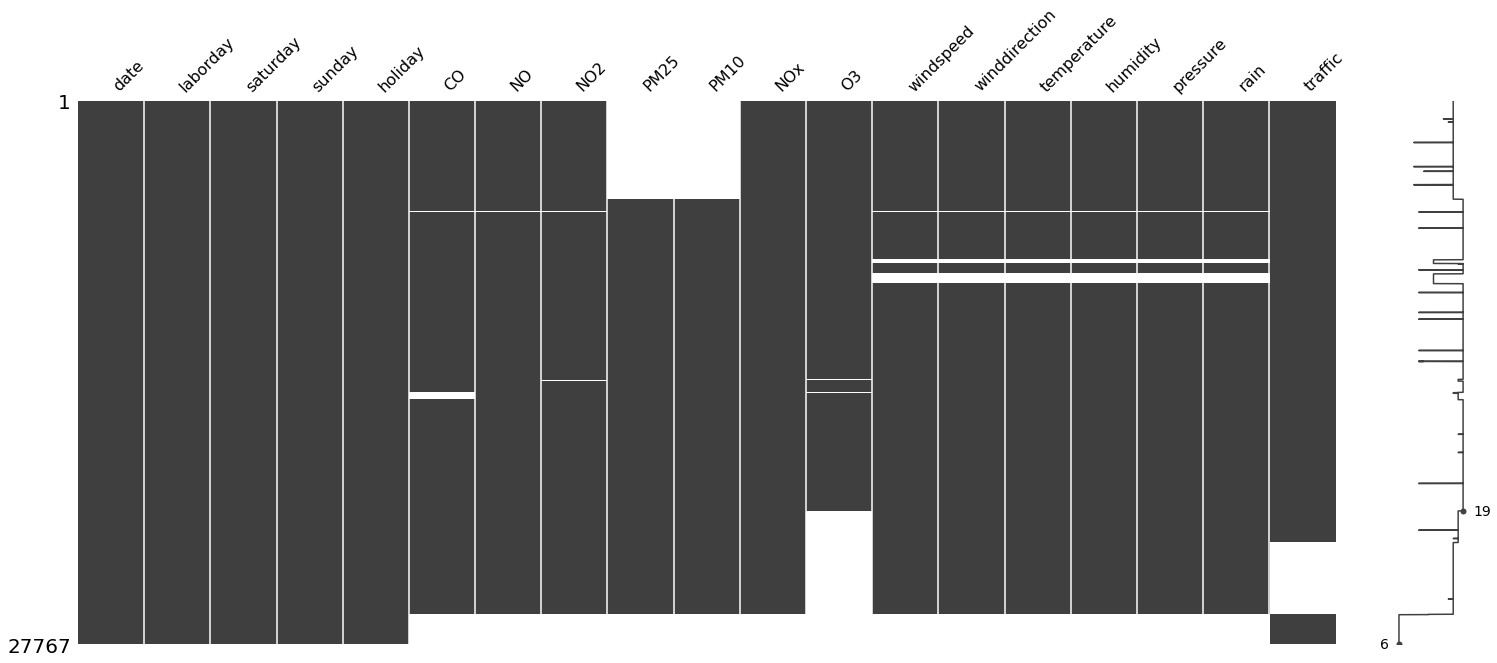

In [11]:
msno.matrix(collistions)

> This bar chart shows the number of data in each column, and the total number of rows is 100%. It can be seen that PM2.5, PM10 and O3 have more missing data.

<AxesSubplot:>

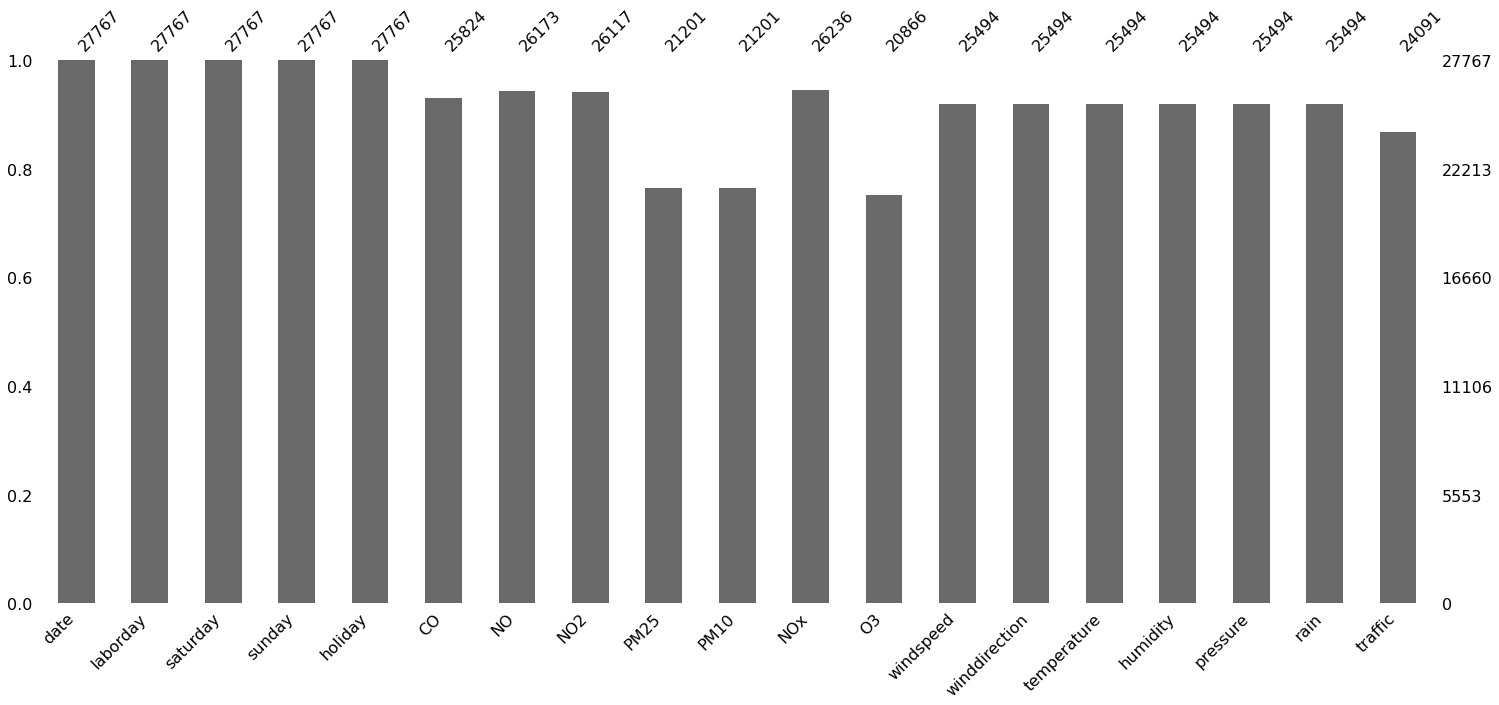

In [12]:
msno.bar(collistions)

> The missingno correlation heatmap can show invalid correlations: how strongly the presence or absence of one variable affects the presence of the other.
A value of 1: one of the two variables is missing and the other must be missing;
A value of -1: one variable is missing and the other variable is not missing.
A value of 0: the presence or absence of missing values for the variable has no effect on each other.

<AxesSubplot:>

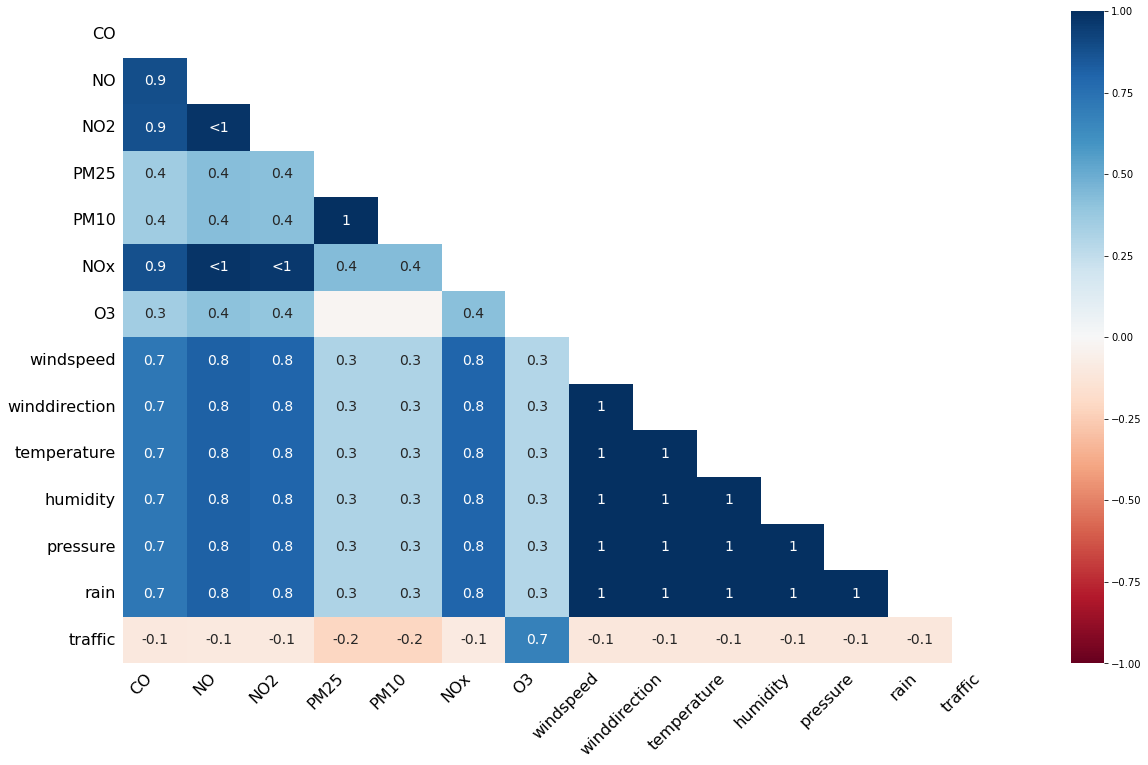

In [13]:
msno.heatmap(collistions)

> The dendrogram uses a hierarchical clustering algorithm to classify variables from each other by their null correlation (measured by binary distance). At each step of the tree, the variables are split according to which combination minimizes the distance of the remaining clusters. The more monotonic the set of variables, the closer their total distance is to zero, and the closer their average distance (y-axis) is to zero. Clusters of leaves linked together at zero distance are perfectly predictable of each other's existence - one variable may always be empty when the other is filled, or they may always be filled or both empty, and so on.

<AxesSubplot:>

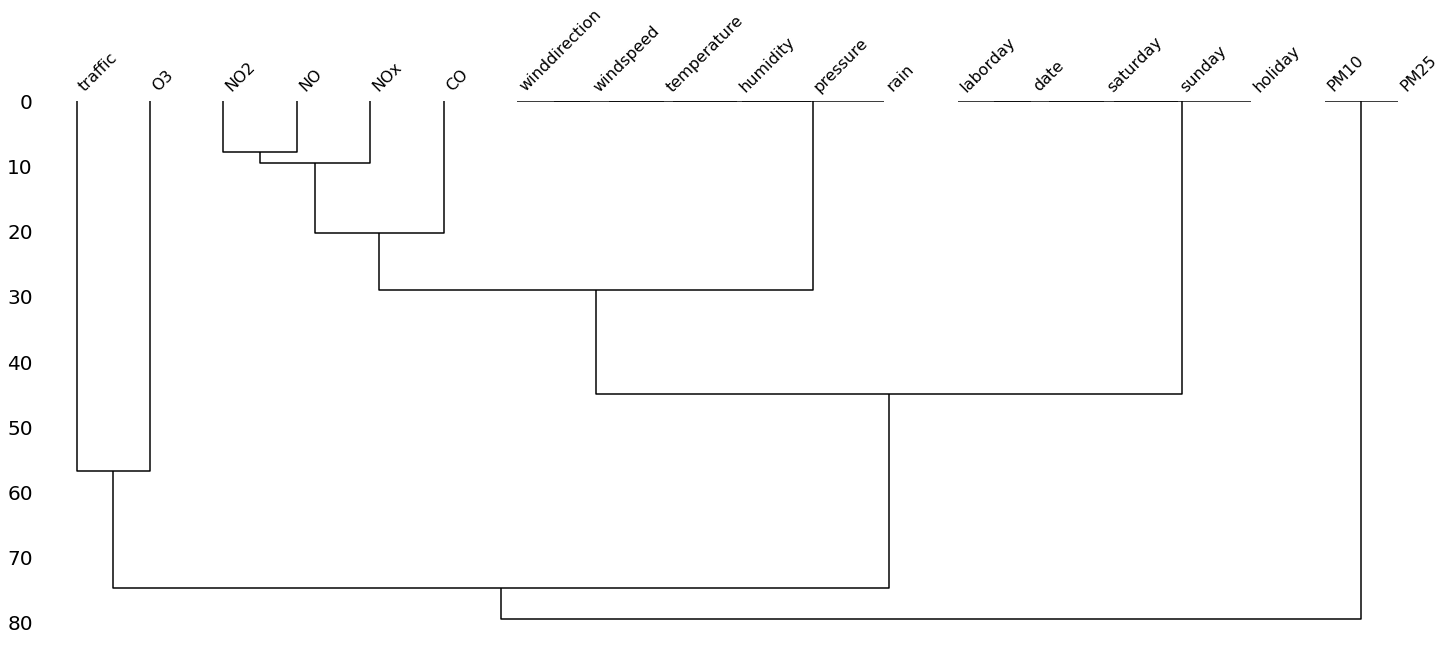

In [14]:
msno.dendrogram(collistions)

## Data output
According to the work of Zhao Hu and the dendrogram chart we know that NO,NO2 and NOx are highly correlated, and since they are related to the same pollutant we will keep just NOx, removing the other two. The same happens with PM2.5 and PM10, we can keep just PM2.5 that is highly correlated (and in fact includes) PM10, removing this last one.

In [5]:
# Print dataframe shape
print(f'Data size before cleaning: {collistions.shape}\n')
# Drop NO NO2 And PM10
df = collistions.drop(['NO', 'NO2', 'PM10'], axis=1)

# Processing date
df = df.dropna()
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute
df['second'] = df['date'].dt.second

idx = ['year', 'month', 'day', 'hour', 'minute', 'second']
# Drop Date
new_df = df.drop(['date'], axis=1)
# Rearrange
new_df = new_df[idx + [col for col in new_df.columns if col not in idx]]

print(new_df.head(), '\n')
print(f'Data size after cleaning: {new_df.shape}')

# Export csv
new_df.to_csv('madpollution_output.csv', index=False)

Data size before cleaning: (27767, 19)

      year  month  day  hour  minute  second  laborday  saturday  sunday  \
5035  2019      8    1     0       0       0         0         1       0   
5036  2019      8    1     1       0       0         0         1       0   
5037  2019      8    1     2       0       0         0         1       0   
5038  2019      8    1     3       0       0         0         1       0   
5039  2019      8    1     4       0       0         0         1       0   

      holiday  ...  PM25   NOx     O3  windspeed  winddirection  temperature  \
5035        0  ...  10.0  29.0  58.87       1.84           97.0         26.1   
5036        0  ...  10.0  18.0  63.73       1.97          117.0         24.9   
5037        0  ...   9.0  19.0  66.50       1.72           96.0         24.0   
5038        0  ...  10.0  15.0  66.62       1.55          106.0         23.3   
5039        0  ...  10.0  18.0  62.57       1.13           67.0         22.9   

      humidity  pressu